## Data enhancement

In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Pre-processing images in data
** note that only training data will undergo enhancement

#### Image enhancement
The process of improving the appearance of images to highlight specific features, reduce noise or improve the quality of the image, this helps it to be more suitable for analysis.

Alpha focuses on the contrast of image
- alpha greater than 1: images brighter, enhanced contrast
- alpha less than 1: images darker, reduced contrast

Beta focuses on brightness of image
- beta positive: makes images brighter
- beta negative: makes images darker

In [2]:
train_data = pd.read_csv("datasets/csv/train_data.csv")
test_data = pd.read_csv("datasets/csv/test_data.csv")

## PREPROCESSING IMAGES WITH ENHANCEMENT
def preprocess_image(img_path, enhance):
    # reading images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if enhance == True:
        # enhancing image
        img = cv2.convertScaleAbs(img, alpha = 1.5, beta = -20)
    # target_size of 224, 224 commonly used for image classification
    img = cv2.resize(img, (224, 224))
    # normalising pixel values
    img_array = img.astype(np.float32) / 255
    return img_array

In [3]:
# using preprocessed images as train data
train_images = np.array([preprocess_image(image_path, True) for image_path in train_data["image_path"]])
# using "pathology" column as train labels
train_labels = np.array(train_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
train_labels[train_labels == "BENIGN_WITHOUT_CALLBACK"] = "BENIGN"

In [5]:
# using preprocessed images as test data
test_images = np.array([preprocess_image(image_path, False) for image_path in test_data["image_path"]])
# using "pathology" column as test labels
test_labels = np.array(test_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
test_labels[test_labels == "BENIGN_WITHOUT_CALLBACK"] = "BENIGN"

Previously, no validation set was being used. ```train_test_split``` will be used to create a validation set, the train, validate and test set will be a 80-10-10 split for this project

In [6]:
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size = 0.5, random_state = 28)

#### Image augmentation
The augmented image stores the following:
- original image without enhancement
- enhanced image with enhancement
- all combinations of augmented flips (with enhancement)
- all combinations of augmented flips (without enhancement)

In [7]:
## IMAGE AUGMENTATION - using numpy
augmented_images = []
augmented_labels = []

# augmenting images and storing in lists
for i, img_path in enumerate(train_data["image_path"]):
    original_image = preprocess_image(img_path, False)
    enhanced_image = preprocess_image(img_path, True)
    
    # making all combinations of flips
    for horizontal_flip in [True, False]:
        for vertical_flip in [True, False]:
            # applying flips on original image
            augmented_image = original_image
            if horizontal_flip:
                augmented_image = np.fliplr(augmented_image)
            if vertical_flip:
                augmented_image = np.flipud(augmented_image)
                
            # adding augmented image and label
            augmented_images.append(augmented_image)
            augmented_labels.append(train_labels[i])
            
            # applying flips on enhanced image
            augmented_image = enhanced_image
            if horizontal_flip:
                augmented_image = np.fliplr(augmented_image)
            if vertical_flip:
                augmented_image = np.flipud(augmented_image)
                
            # adding augmented image and label
            augmented_images.append(augmented_image)
            augmented_labels.append(train_labels[i])
        
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [8]:
# encoding labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_aug_train_labels = label_encoder.fit_transform(augmented_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)
# one-hot encode labels
one_hot_train_labels = tf.keras.utils.to_categorical(encoded_train_labels)
one_hot_aug_train_labels = tf.keras.utils.to_categorical(encoded_aug_train_labels)
one_hot_val_labels = tf.keras.utils.to_categorical(encoded_val_labels)

## Creating of models
- **Conv2D** performs convolutional operations on the input image data. It applies a set of filters to the input images to extract features.
- **MaxPooling2D** is a down-sampling operation that reduces the spatial dimensions, used after Conv2D layers to retain the most important information.
- **Flatten** is used to convert the multi-dimensional output of the previous laters into 1D.
- **Dense** represents a fully connected layer, where each neuron or node is connected to every neuron in the previous layer.

Setting verbose = 0 ensures that nothing is printed during the training of the model.

### Base model
Ensures that the data can be trained on.

In [9]:
## EXISTING BASE MODEL
base_model = Sequential()
# creating stack of Conv2D and MaxPooling2D
base_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
base_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
base_model.add(Flatten())
base_model.add(Dense(128, activation = "relu"))
# output layer with softmax
base_model.add(Dense(2, activation = "softmax"))

10/10 - 1s - loss: 1.6535 - accuracy: 0.6463 - 928ms/epoch - 93ms/step
val accuracy: 0.646258533000946


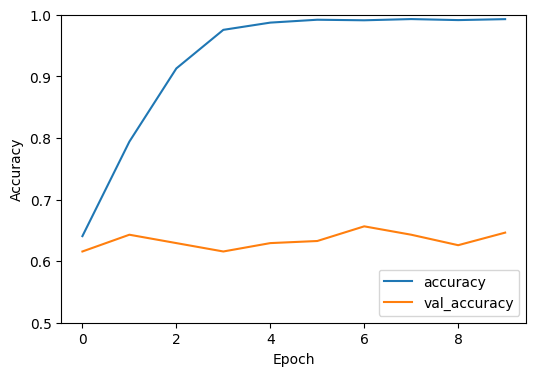

In [10]:
# compile model, improving accuracy
base_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = base_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (val_images, one_hot_val_labels), verbose = 0)

# evaluating the base_model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = base_model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

#### Adding layers to model to fit
To make the model perform better, additional Convolutional layers are added. Each ```Conv2D``` layer is paired with a ```MaxPooling``` layer to reduce the model's dimensionality.

**Findings**: it performed worse with the original validation accuracy of 64.6% dropping to 59.2%

In [17]:
## EXISTING BASE MODEL
base_improved_model = Sequential()
base_improved_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
base_improved_model.add(MaxPooling2D((2, 2)))
base_improved_model.add(Dense(128, activation = "relu"))
base_improved_model.add(Dense(2, activation = "softmax"))

## ADDITIONAL LAYERS
# creating more stacks of Conv2D and MaxPooling2D
base_improved_model.add(Conv2D(64, (3, 3), activation = "relu"))
base_improved_model.add(MaxPooling2D((2, 2)))
base_improved_model.add(Conv2D(128, (3, 3), activation = "relu"))
base_improved_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
base_improved_model.add(Flatten())
base_improved_model.add(Dense(128, activation = "relu"))
# output layer with softmax
base_improved_model.add(Dense(2, activation = "softmax"))

10/10 - 2s - loss: 1.9892 - accuracy: 0.5918 - 2s/epoch - 164ms/step
val accuracy: 0.5918367505073547


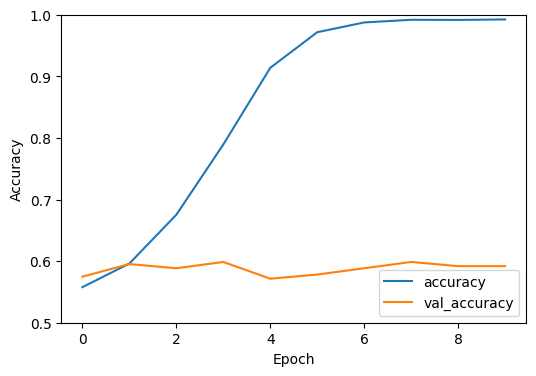

In [18]:
# compile model, improving accuracy
base_improved_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = base_improved_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (val_images, one_hot_val_labels), verbose = 0)

# evaluating the base_improved_model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = base_improved_model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

#### Increasing complexity of neural network
To attempt to make the model perform better, the Dense layers will have a higher number of neurons, instead of adding 2 Dense layers of 128 neurons.

### Improving with additional layers

In [26]:
## MODIFIED BASE MODEL
threeLayer_model = Sequential()
threeLayer_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
threeLayer_model.add(MaxPooling2D((2, 2)))

# creating more stacks of Conv2D and MaxPooling2D
threeLayer_model.add(Conv2D(64, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))
threeLayer_model.add(Conv2D(128, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
threeLayer_model.add(Flatten())
threeLayer_model.add(Dense(256, activation = "relu"))
threeLayer_model.add(Dense(128, activation = "relu"))
# output layer with softmax
threeLayer_model.add(Dense(2, activation = "softmax"))

In [ ]:
# compile model, improving accuracy
threeLayer_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = threeLayer_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (val_images, one_hot_val_labels), verbose = 0)

# evaluating the threeLayer_model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = threeLayer_model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

#### Reducing batch size
As there is a large set of data for the model to train on, it would provide the benefit of memory efficiency. With the introduction to image augmentation and enhancement, the large dataset would benefit from using a batch size to run.

In addition, training with a batch introduces noise during each iteration which can be a form of regularisation and generalisation (seeing a diverse set of examples in each iteration) which prevent overfitting.

For this project, a relatively medium batch size of 256 will be implemented. It is noted that a common batch size being used is either 32 or 64.

The ```threeLayer_model``` will be reused for training to compare the significance of batch size.

In [ ]:
# compile model, improving accuracy
threeLayer_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on validation set
history = threeLayer_model.fit(augmented_images, one_hot_aug_train_labels, 
                               epochs = 10, batch_size = 256, verbose = 0,
                               validation_data = (val_images, one_hot_val_labels))

# evaluating the threeLayer_model
plt.figure(figsize = (6, 4))
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
val_loss, val_acc = threeLayer_model.evaluate(val_images, one_hot_val_labels, verbose = 2)
print("val accuracy:", val_acc)

# IGNORE BELOW

In [10]:
twoLayer_model = Sequential()

# first convolutional layer
twoLayer_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
twoLayer_model.add(MaxPooling2D((2, 2)))

# second convolutional layer
twoLayer_model.add(Conv2D(64, (3, 3), activation = "relu"))
twoLayer_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
twoLayer_model.add(Flatten())
twoLayer_model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
twoLayer_model.add(Dropout(0.5))
# output layer with softmax
twoLayer_model.add(Dense(2, activation = "softmax"))

In [11]:
# compile model, improving accuracy
twoLayer_model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on test set
history = twoLayer_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))

Epoch 1/10
588/588 [==============================] - 479s 812ms/step - loss: 0.6562 - accuracy: 0.6080 - val_loss: 0.6250 - val_accuracy: 0.6327
Epoch 2/10
588/588 [==============================] - 481s 817ms/step - loss: 0.5299 - accuracy: 0.7149 - val_loss: 0.6374 - val_accuracy: 0.6582
Epoch 3/10
588/588 [==============================] - 481s 819ms/step - loss: 0.3602 - accuracy: 0.8337 - val_loss: 0.7174 - val_accuracy: 0.6701
Epoch 4/10
588/588 [==============================] - 484s 822ms/step - loss: 0.2244 - accuracy: 0.9104 - val_loss: 1.0432 - val_accuracy: 0.6327
Epoch 5/10
588/588 [==============================] - 473s 805ms/step - loss: 0.1525 - accuracy: 0.9467 - val_loss: 1.1916 - val_accuracy: 0.6276
Epoch 6/10
588/588 [==============================] - 473s 804ms/step - loss: 0.1077 - accuracy: 0.9645 - val_loss: 1.2773 - val_accuracy: 0.6395
Epoch 7/10
588/588 [==============================] - 475s 807ms/step - loss: 0.0979 - accuracy: 0.9731 - val_loss: 1.1370 -

In [12]:
threeLayer_model = Sequential()

# first convolutional layer
threeLayer_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
threeLayer_model.add(MaxPooling2D((2, 2)))

# second convolutional layer
threeLayer_model.add(Conv2D(64, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))

# third convolutional layer
threeLayer_model.add(Conv2D(128, (3, 3), activation = "relu"))
threeLayer_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
threeLayer_model.add(Flatten())
threeLayer_model.add(Dense(128, activation = "relu"))
# using dropout for regularisation (reduces overfitting)
threeLayer_model.add(Dropout(0.5))
# output layer with softmax
threeLayer_model.add(Dense(2, activation = "softmax"))

In [13]:
# compile model, improving accuracy
threeLayer_model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on test set
history = threeLayer_model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))

Epoch 1/10
588/588 [==============================] - 581s 984ms/step - loss: 0.6616 - accuracy: 0.5857 - val_loss: 0.6722 - val_accuracy: 0.5799
Epoch 2/10
588/588 [==============================] - 581s 988ms/step - loss: 0.6052 - accuracy: 0.6442 - val_loss: 0.6219 - val_accuracy: 0.6105
Epoch 3/10
588/588 [==============================] - 587s 998ms/step - loss: 0.5289 - accuracy: 0.7019 - val_loss: 0.6694 - val_accuracy: 0.6224
Epoch 4/10
588/588 [==============================] - 578s 982ms/step - loss: 0.4390 - accuracy: 0.7646 - val_loss: 0.7516 - val_accuracy: 0.6156
Epoch 5/10
588/588 [==============================] - 575s 978ms/step - loss: 0.3412 - accuracy: 0.8313 - val_loss: 0.9032 - val_accuracy: 0.5935
Epoch 6/10
588/588 [==============================] - 573s 974ms/step - loss: 0.2748 - accuracy: 0.8681 - val_loss: 0.9765 - val_accuracy: 0.6224
Epoch 7/10
588/588 [==============================] - 583s 991ms/step - loss: 0.2209 - accuracy: 0.9004 - val_loss: 1.4466 -

### Hyperparameter tuning
To conduct hyperparameter tuning, it is beneficial to wrap the model in a function. This makes it scikit-learn compatable as there will be methods like Grid Search and Randomised Search to help optimise the performance of the neural network.

As more runs will be done, adding verbose = 2 makes the information printed a single line.

In [14]:
# defining model as a function
def create_3Layer_model(dropout_rate = 0.5, **kwargs):
    model = Sequential()

    # first convolutional layer
    model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))

    # second convolutional layer
    model.add(Conv2D(64, (3, 3), activation = "relu"))
    model.add(MaxPooling2D((2, 2)))

    # third convolutional layer
    model.add(Conv2D(128, (3, 3), activation = "relu"))
    model.add(MaxPooling2D((2, 2)))

    # unrolling output to 1D
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    # using dropout for regularisation (reduces overfitting)
    model.add(Dropout(dropout_rate))
    # output layer with softmax
    model.add(Dense(2, activation = "softmax"))
    
    # compile model, improving accuracy
    model.compile(optimizer = "Nadam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    # train model, validating on test set
    history = model.fit(augmented_images, one_hot_aug_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))
    
    return model, history

#### Conducting Grid Search
[modify]
Grid search involves defining a grid of hyperparameter values and training the model for each combination. It's a brute-force approach that explores a predefined set of hyperparameter values.

```
# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'optimizer': ['adam', 'nadam', 'rmsprop'],
    'dropout_rate': [0.2, 0.4, 0.6],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(augmented_images, one_hot_aug_train_labels)
```

In [15]:
# creating the Keras classifier
model_for_grid = KerasClassifier(build_fn = create_3Layer_model, epochs = 10, batch_size = 32, verbose = 2)

# defining hyperparameters
parameter = {
    'dropout_rate': [0.2, 0.3, 0.4, 0.5]
}

# performing grid search - 5 fold grid search
grid_search = GridSearchCV(estimator = model_for_grid, param_grid = parameter)
grid_result = grid_search.fit(augmented_images, one_hot_aug_train_labels)

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0.2)`
Check the list of available parameters with `estimator.get_params().keys()`

#### Conducting Random Search
[modify] Random search randomly samples hyperparameter values from predefined ranges. It is more efficient than grid search and can be effective in high-dimensional spaces.

```
from scipy.stats import uniform

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their distributions to sample from
param_dist = {
    'optimizer': ['adam', 'nadam', 'rmsprop'],
    'dropout_rate': uniform(0.2, 0.6),
}

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_result = random_search.fit(augmented_images, one_hot_aug_train_labels)
```

In [17]:
cross entropy

SyntaxError: invalid syntax (598597257.py, line 1)

In [16]:
from scipy.stats import uniform

# creating the Keras classifier
model_for_rand = KerasClassifier(build_fn = create_3Layer_model, epochs = 10, batch_size = 32, verbose = 2)

# defining hyperparameters
parameter = {
    'dropout_rate': uniform(0.2, 0.5)
}

# performing grid search - 5 fold grid search
rand_search = RandomizedSearchCV(estimator = model_for_rand, param_distributions = parameter)
rand_result = rand_search.fit(augmented_images, one_hot_aug_train_labels)

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0.24614573914080118)`
Check the list of available parameters with `estimator.get_params().keys()`